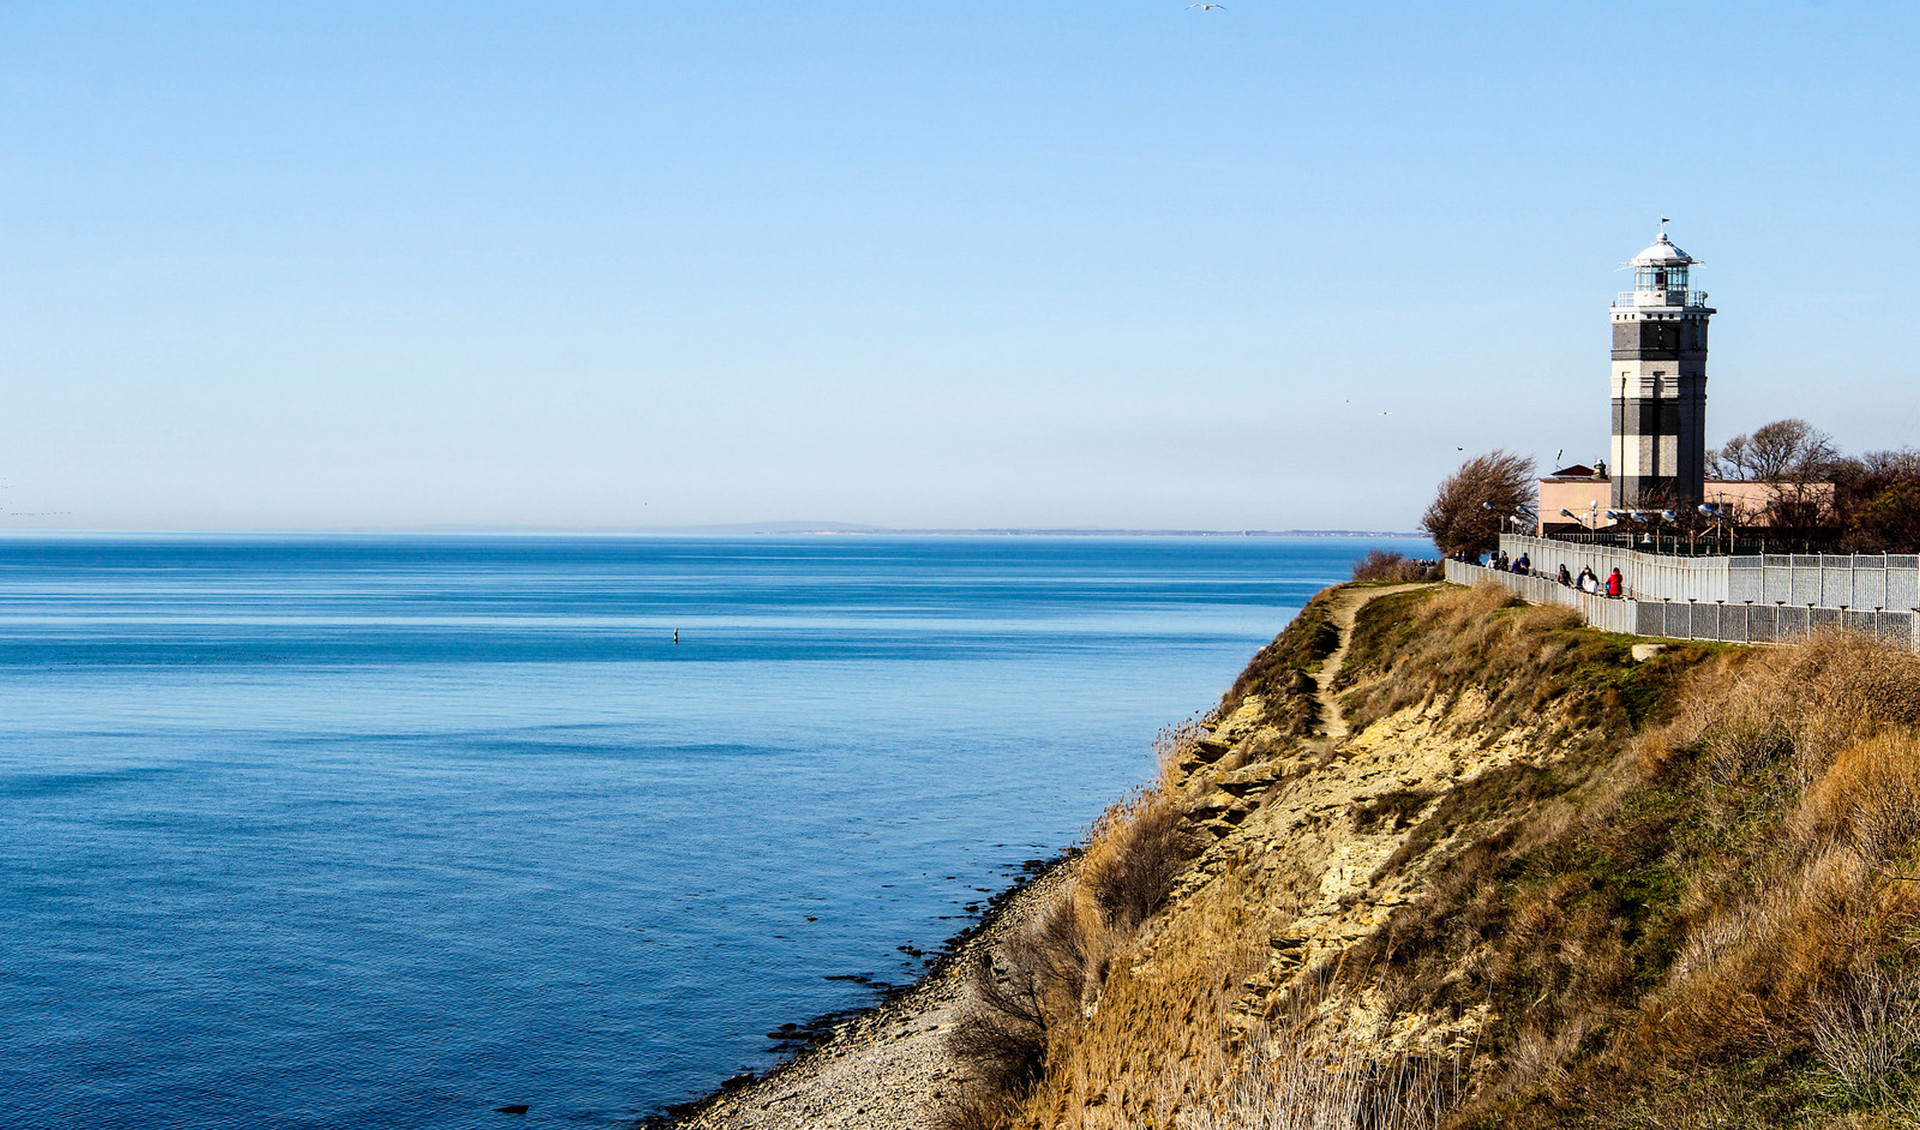

# Общая информация. Задача

Анапа - курортный город на юге России, у побережья Чёрного моря.  
Температура воздуха зимой почти всегда положительная, Новый год в Анапе можно отпраздновать при +15, а иногда и при +20.  
Помимо пляжного отдыха летом, существует и другой туристический интерес - это лечение в Анапских санаториях и здравницах.  


Мы попытаемся узнать на основе данных за зимние месяцы 2017 года выяснить, какие рейсы из Анапы можно исключить для увеличения прибыльности нашей авиакомпании.

# Первичная обработка данных

In [160]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=3)
import seaborn as sns
from math import radians, cos, sin, asin, sqrt
pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

avia = pd.read_csv('avia.csv')



'''Функция гаверсинуса для определения расстояния между двумя точками'''


def haversine(row):
    lon1 = row['departure_longitude']
    lat1 = row['departure_latitude']
    lon2 = row['arrival_longitude']
    lat2 = row['arrival_latitude']
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    return km


'''Формула для быстрой группировки столбцов'''
def group_value(col1, col2):
    return avia.groupby(by=col1)[col2].value_counts()
    

# меняем формат столбца для удобства работы с ним
avia['scheduled_departure'] = pd.to_datetime(avia['scheduled_departure'])


'''Формула для построения bar chart'''


def barplot(col1, col2):
    ax = sns.barplot(x=col1, y=col2, data=avia)
    return ax

# удельный расход топлива, кг/ч
fuel_consumption = {'733': 2600, 'SU9':1700}

# средняя стоимость топлива в зимние месяцы, руб/т
fuel_cost = {1: 41435, 2:39553, 12:47101}


'''Формула определения затрат на рейс'''


def cost(row):
    duration_in_hour = row['flight_duration']/60 # получаем часы из длительности в минутах
    cost_in_kg = fuel_cost[row['departure_month']]/1000 # рассчитываем стоимость топлива в кг
    fuel_consump = fuel_consumption[row['aircraft_code']]
    return duration_in_hour*cost_in_kg*fuel_consump


'''Формула, выводящая график плотности распределения переменных (boxplot)'''


def get_boxplot(column):
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=column, y='profit',
                data=avia.loc[avia.loc[:, column].isin(
                    avia.loc[:, column].value_counts().index[:10])], palette="Blues",
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()
    

'''Формула для сортировки данных (head)'''


def sort_head(df, col, number):
    return df.sort_values(by=col, ascending=False).head(number)


'''Формула для сортировки данных (tail)'''

def sort_tail(df, col, number):
    return df.sort_values(by=col, ascending=False).tail(number)



# Анализ данных

In [161]:
avia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   flight_id                 118 non-null    int64              
 1   aircraft_code             118 non-null    object             
 2   model                     118 non-null    object             
 3   range                     118 non-null    int64              
 4   departure_airport         118 non-null    object             
 5   departure_latitude        118 non-null    float64            
 6   departure_longitude       118 non-null    float64            
 7   arrival_airport           118 non-null    object             
 8   arrival_latitude          118 non-null    float64            
 9   arrival_longitude         118 non-null    float64            
 10  scheduled_departure       118 non-null    datetime64[ns, UTC]
 11  scheduled_arrival  

В датасете 24 столбца, 118 строк. Пропущенных значений нет

| Название столбца | Содержание                     |
|:-----------------|:---------------------------------|
| flight_id | идентификатор рейса |
| aircraft_code | код самолета, IATA |
| model | модель самолета |
| range |максимальная длительность полета, км|
| departure_airport | аэропорт отправления |
| departure_latitude | широта аэропорта отправления |
| departure_longitude | долгота аэропорта отправления |
| arrival_airport | аэропорт прибытия |
| arrival_latitude | широта аэропорта прибытия |      
| arrival_longitude | долгота аэропорта прибытия |
| scheduled_departure | время вылета по расписанию |
| scheduled_arrival | время прилета по расписанию |
| flight_duration | длительность рейса, мин |
| arrival_delay | задержка рейса, мин |
| class_1 | класс обслуживания 1 |
| ticket_quantity_business | количество билетов бизнес |
| amount_business | общая стоимость билетов бизнес |
| avg_price_business | средняя стоимость билета бизнес |
| class_2 | класс обслуживания 2 |
| ticket_quantity_economy | количество билетов эконом |
| amount_economy | общая стоимость билетов эконом |
| avg_price_economy | средняя стоимость билета эконом |
| business_seats | количество мест бизнес |
| economy_seats | количество мест эконом |

In [162]:
avia['flight_id'].nunique()

118

Все рейсы в представленном датасете уникальны, дублирующих значений нет.

In [163]:
group_value('arrival_airport', 'aircraft_code')

arrival_airport  aircraft_code
EGO              SU9              59
SVO              733              59
Name: aircraft_code, dtype: int64

Один аэропорт обслуживает одна и та же модель самолета, количество рейсов в зимние месяцы поровну на два города - Москва и Белгород.  

In [164]:
group_value('model', 'range')

model                range
Boeing 737-300       4200     59
Sukhoi Superjet-100  3000     59
Name: range, dtype: int64

Максимальная дальность полета Boeing 737-300 на 40% больше, чем у Sukhoi Superjet-100.  
Попробуем, выяснить, обусловлен ли выбор модели расстоянием между аэропортами.

In [165]:
avia['distance'] = avia.apply(lambda row: haversine(row), axis=1)
group_value('arrival_airport', 'distance')

arrival_airport  distance   
EGO              629.465099     59
SVO              1219.106867    59
Name: distance, dtype: int64

Да, мы видим, что расстояние между Анапой и Москвой почти в два раза больше расстояния с Белгородом.

In [166]:
# проверим задержки рейса
sort_head(avia, 'arrival_delay', 5)

,flight_id,aircraft_code,model,range,departure_airport,departure_latitude,departure_longitude,arrival_airport,arrival_latitude,arrival_longitude,scheduled_departure,scheduled_arrival,flight_duration,arrival_delay,class_1,ticket_quantity_business,amount_business,avg_price_business,class_2,ticket_quantity_economy,amount_economy,avg_price_economy,business_seats,economy_seats,distance
35,136345,733,Boeing 737-300,4200,AAQ,45.002102,37.347301,SVO,55.972599,37.414600,2017-01-24 10:05:00+00:00,2017-01-24T11:45:00Z,100.0,207.0,Business,8,292800.0,36600.0,Economy,100,1224800.0,12248.000000,12,118,1219.106867
67,136632,SU9,Sukhoi Superjet-100,3000,AAQ,45.002102,37.347301,EGO,50.643799,36.590099,2017-01-07 09:25:00+00:00,2017-01-07T10:15:00Z,50.0,198.0,Business,11,207900.0,18900.0,Economy,80,506400.0,6330.000000,12,85,629.465099
101,136855,SU9,Sukhoi Superjet-100,3000,AAQ,45.002102,37.347301,EGO,50.643799,36.590099,2017-01-11 09:25:00+00:00,2017-01-11T10:15:00Z,50.0,162.0,Business,12,226800.0,18900.0,Economy,75,475500.0,6340.000000,12,85,629.465099
117,136956,SU9,Sukhoi Superjet-100,3000,AAQ,45.002102,37.347301,EGO,50.643799,36.590099,2017-02-04 09:25:00+00:00,2017-02-04T10:15:00Z,50.0,8.0,Business,11,207900.0,18900.0,Economy,85,538500.0,6335.294118,12,85,629.465099
37,136351,733,Boeing 737-300,4200,AAQ,45.002102,37.347301,SVO,55.972599,37.414600,2017-02-26 10:05:00+00:00,2017-02-26T11:45:00Z,100.0,8.0,Business,11,402600.0,36600.0,Economy,94,1152800.0,12263.829787,12,118,1219.106867


Очень сильно выбиваются рейсы 136345, 136632, 136855. К сожалению, у нас мало данных для выяснения причин.  
Радует, что не считая рейсы-исключения опоздания крайне невелики.

Добавим новые показатели для оценки прибыльности рейса:
1. Выполненный пассажирооборот (RPK)
2. Предельный пассажирооборот (ASK)
3. Суммарный дохож (EBITDAR)
4. Процент занятости пассажирских кресел (SLF)

In [167]:
# отношение количества выкупленных мест к пройденному расстоянию
avia['RPK'] = (avia['ticket_quantity_business'] + avia['ticket_quantity_economy'])*avia['distance']

In [168]:
# отношение количества всех пассажирских кресел в самолете к пройденному расстоянию
avia['ASK'] = (avia['business_seats']+avia['economy_seats'])*avia['distance']

In [169]:
avia['EBITDAR'] = avia['amount_business']+avia['amount_economy']

In [170]:
avia['SLF'] = 100*(avia['RPK']/avia['ASK'])

Проверим зависимость цены на билет и загрузкой кресел в каждом сегменте обслуживания

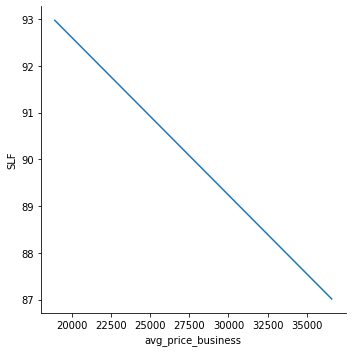

In [171]:
sns.relplot(x="avg_price_business", y="SLF", ci=None, kind="line", data=avia)

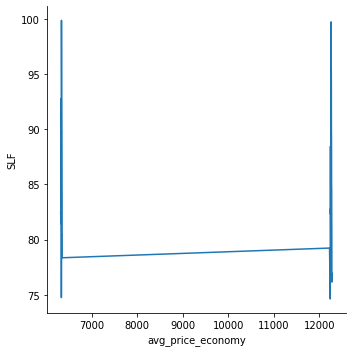

In [172]:
sns.relplot(x="avg_price_economy", y="SLF", ci=None, kind="line", data=avia)

Неожиданные результаты. Как правило, именно эконом-класс чувствителен к повышению цен.  
Мы видим, что при верхней и нижней границах бывают самые разные варианты загрузки кресел. Возможно, билеты с большей ценой люди покупали в последний момент. Плюс, нужно не забывать о политике цен: в праздничные, выходные дни цена справедливо может быть выше  

А вот такой драматичный спад загрузки пассажирских кресел интересен для премиум-сегмента. Возможно, дело не в самой высокой цене для бизнес-класса в перелетах по СНГ(плюс, Анапа - это все-таки не юг Франции), а значит, эти люди все же острее реагируют на смену цены.  

Также мы можем отметить широкий диапазон средней цены в бизнес-классе, он шире в три раза чем у эконом-класса. Скорее всего, это объясняется разницей цены билетов с Москвы и Белгорода.

Так как у нас нет возможности отследить стоимость топлива на каждом рейсе, будем считать, что самолеты заправлялись в аэрпорту Анапы

[Цены на авиационное топливо в 2017г](https://favt.gov.ru/dejatelnost-ajeroporty-i-ajerodromy-ceny-na-aviagsm-statistika-aviagsm/?id=3241)

In [173]:
# добавим столбец с месяцем отправления для отслеживания фин.показателей 
# и расчета стоимости рейса
avia['departure_month'] = avia['scheduled_departure'].dt.month

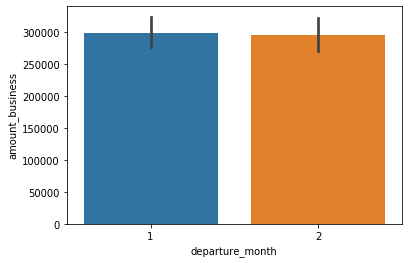

In [174]:
barplot("departure_month", "amount_business")

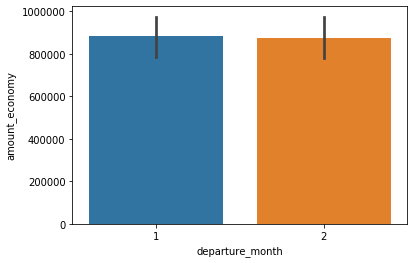

In [175]:
barplot("departure_month", "amount_economy")

Интересно, что в датасет не попали данные за декабрь. Будем надеяться, это человеческий фактор (забыли заполнить), а не метрвый сезон.  
В целом, мы видим, что особой разницы между месяцами ни в одном сегменте нет

In [176]:
# добавляем столбец с затратами на рейс
avia['flight_cost'] = avia.apply(lambda x: cost(x), axis=1)

# считаем прибыльность рейсов
avia['profit'] = (avia['amount_business'] + avia['amount_economy']) - avia['flight_cost']
avia['profit'] = avia['profit'].apply(lambda x: int(x))

In [177]:
# выделим самые убыточные рейсы
sort_tail(avia, 'profit', 5)

,flight_id,aircraft_code,model,range,departure_airport,departure_latitude,departure_longitude,arrival_airport,arrival_latitude,arrival_longitude,scheduled_departure,scheduled_arrival,flight_duration,arrival_delay,class_1,ticket_quantity_business,amount_business,avg_price_business,class_2,ticket_quantity_economy,amount_economy,avg_price_economy,business_seats,economy_seats,distance,RPK,ASK,EBITDAR,SLF,departure_month,flight_cost,profit
111,136922,SU9,Sukhoi Superjet-100,3000,AAQ,45.002102,37.347301,EGO,50.643799,36.590099,2017-02-11 09:25:00+00:00,2017-02-11T10:15:00Z,50.0,2.0,Business,10,189000.0,18900.0,Economy,66,418800.0,6345.454545,12,85,629.465099,47839.347560,61058.114649,607800.0,78.350515,2,56033.416667,551766
107,136887,SU9,Sukhoi Superjet-100,3000,AAQ,45.002102,37.347301,EGO,50.643799,36.590099,2017-01-20 09:25:00+00:00,2017-01-20T10:15:00Z,50.0,4.0,Business,8,151200.0,18900.0,Economy,70,444000.0,6342.857143,12,85,629.465099,49098.277759,61058.114649,595200.0,80.412371,1,58699.583333,536500
100,136844,SU9,Sukhoi Superjet-100,3000,AAQ,45.002102,37.347301,EGO,50.643799,36.590099,2017-02-28 09:25:00+00:00,2017-02-28T10:15:00Z,50.0,1.0,Business,6,113400.0,18900.0,Economy,73,461700.0,6324.657534,12,85,629.465099,49727.742859,61058.114649,575100.0,81.443299,2,56033.416667,519066
93,136807,SU9,Sukhoi Superjet-100,3000,AAQ,45.002102,37.347301,EGO,50.643799,36.590099,2017-02-23 09:25:00+00:00,2017-02-23T10:15:00Z,50.0,3.0,Business,8,151200.0,18900.0,Economy,60,379800.0,6330.000000,12,85,629.465099,42803.626764,61058.114649,531000.0,70.103093,2,56033.416667,474966
68,136642,SU9,Sukhoi Superjet-100,3000,AAQ,45.002102,37.347301,EGO,50.643799,36.590099,2017-01-30 09:25:00+00:00,2017-01-30T10:15:00Z,50.0,2.0,Business,10,189000.0,18900.0,Economy,54,342000.0,6333.333333,12,85,629.465099,40285.766366,61058.114649,531000.0,65.979381,1,58699.583333,472300


Все 5 аутсайдеров из аэропорта Белгорода. Возможно, дело в том, что самолеты меньше, цены ниже, соответственно и прибыль будет меньше

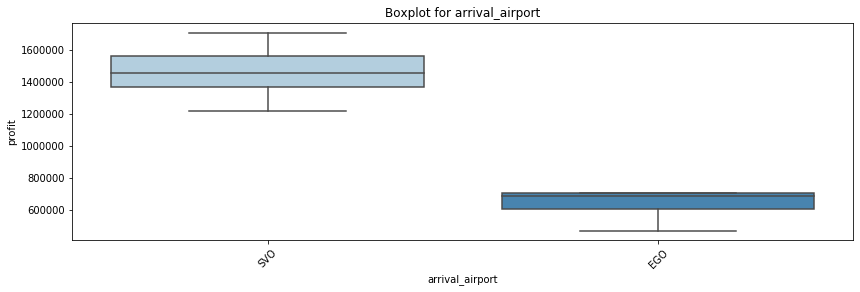

In [178]:
get_boxplot('arrival_airport')

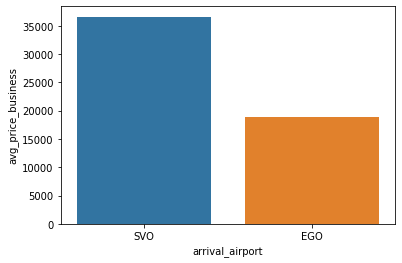

In [179]:
barplot("arrival_airport", "avg_price_business")

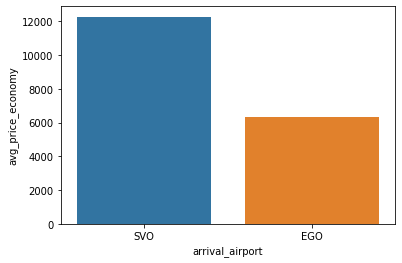

In [180]:
barplot("arrival_airport", "avg_price_economy")

Да, мы видим,что разница в стоимости билетов почти двукратная в каждом из классов обслуживания.  




Генеральный директор Аэрофлота Виталий Савельев в одном из интревью сказал: "...если загрузка кресел меньше, чем 75%, то рейс становится не рентабельным."  
Предлагаю, проверить рейсы на малую заполняемость, прежде чем вносить рейсы в список для исключения

[Ссылка на интервью](https://www.kommersant.ru/doc/3246832)

In [181]:
avia[avia.SLF < 75]

,flight_id,aircraft_code,model,range,departure_airport,departure_latitude,departure_longitude,arrival_airport,arrival_latitude,arrival_longitude,scheduled_departure,scheduled_arrival,flight_duration,arrival_delay,class_1,ticket_quantity_business,amount_business,avg_price_business,class_2,ticket_quantity_economy,amount_economy,avg_price_economy,business_seats,economy_seats,distance,RPK,ASK,EBITDAR,SLF,departure_month,flight_cost,profit
2,136122,733,Boeing 737-300,4200,AAQ,45.002102,37.347301,SVO,55.972599,37.414600,2017-01-08 10:05:00+00:00,2017-01-08T11:45:00Z,100.0,3.0,Business,10,366000.0,36600.0,Economy,87,1065000.0,12241.379310,12,118,1219.106867,118253.366118,158483.892736,1431000.0,74.615385,1,179551.666667,1251448
38,136360,733,Boeing 737-300,4200,AAQ,45.002102,37.347301,SVO,55.972599,37.414600,2017-02-05 10:05:00+00:00,2017-02-05T11:45:00Z,100.0,3.0,Business,11,402600.0,36600.0,Economy,86,1052800.0,12241.860465,12,118,1219.106867,118253.366118,158483.892736,1455400.0,74.615385,2,171396.333333,1284003
68,136642,SU9,Sukhoi Superjet-100,3000,AAQ,45.002102,37.347301,EGO,50.643799,36.590099,2017-01-30 09:25:00+00:00,2017-01-30T10:15:00Z,50.0,2.0,Business,10,189000.0,18900.0,Economy,54,342000.0,6333.333333,12,85,629.465099,40285.766366,61058.114649,531000.0,65.979381,1,58699.583333,472300
93,136807,SU9,Sukhoi Superjet-100,3000,AAQ,45.002102,37.347301,EGO,50.643799,36.590099,2017-02-23 09:25:00+00:00,2017-02-23T10:15:00Z,50.0,3.0,Business,8,151200.0,18900.0,Economy,60,379800.0,6330.000000,12,85,629.465099,42803.626764,61058.114649,531000.0,70.103093,2,56033.416667,474966


По показателю загрузки кресел у нас всего 4 нерентабельных рейса, по два на каждый аэропорт прибытия.  

Посмотрим, есть ли совпадения среди лидеров по прибыльности и заполняемости

In [182]:
sort_head(avia, 'profit', 5)

,flight_id,aircraft_code,model,range,departure_airport,departure_latitude,departure_longitude,arrival_airport,arrival_latitude,arrival_longitude,scheduled_departure,scheduled_arrival,flight_duration,arrival_delay,class_1,ticket_quantity_business,amount_business,avg_price_business,class_2,ticket_quantity_economy,amount_economy,avg_price_economy,business_seats,economy_seats,distance,RPK,ASK,EBITDAR,SLF,departure_month,flight_cost,profit
32,136316,733,Boeing 737-300,4200,AAQ,45.002102,37.347301,SVO,55.972599,37.4146,2017-01-12 10:05:00+00:00,2017-01-12T11:45:00Z,100.0,2.0,Business,12,439200.0,36600.0,Economy,118,1446800.0,12261.016949,12,118,1219.106867,158483.892736,158483.892736,1886000.0,100.000000,1,179551.666667,1706448
19,136226,733,Boeing 737-300,4200,AAQ,45.002102,37.347301,SVO,55.972599,37.4146,2017-01-30 10:05:00+00:00,2017-01-30T11:45:00Z,100.0,3.0,Business,12,439200.0,36600.0,Economy,118,1446800.0,12261.016949,12,118,1219.106867,158483.892736,158483.892736,1886000.0,100.000000,1,179551.666667,1706448
43,136403,733,Boeing 737-300,4200,AAQ,45.002102,37.347301,SVO,55.972599,37.4146,2017-02-20 10:05:00+00:00,2017-02-20T11:45:00Z,100.0,1.0,Business,12,439200.0,36600.0,Economy,117,1434600.0,12261.538462,12,118,1219.106867,157264.785869,158483.892736,1873800.0,99.230769,2,171396.333333,1702403
42,136389,733,Boeing 737-300,4200,AAQ,45.002102,37.347301,SVO,55.972599,37.4146,2017-01-18 10:05:00+00:00,2017-01-18T11:45:00Z,100.0,5.0,Business,12,439200.0,36600.0,Economy,117,1434600.0,12261.538462,12,118,1219.106867,157264.785869,158483.892736,1873800.0,99.230769,1,179551.666667,1694248
46,136423,733,Boeing 737-300,4200,AAQ,45.002102,37.347301,SVO,55.972599,37.4146,2017-01-10 10:05:00+00:00,2017-01-10T11:45:00Z,100.0,7.0,Business,11,402600.0,36600.0,Economy,118,1446800.0,12261.016949,12,118,1219.106867,157264.785869,158483.892736,1849400.0,99.230769,1,179551.666667,1669848


In [183]:
# отсеем сразу EGO аэропорт для выявления рейсов-лидеров, отправившихся в Шереметьево
sort_head(avia[avia.arrival_airport == 'SVO'], 'SLF', 5)

,flight_id,aircraft_code,model,range,departure_airport,departure_latitude,departure_longitude,arrival_airport,arrival_latitude,arrival_longitude,scheduled_departure,scheduled_arrival,flight_duration,arrival_delay,class_1,ticket_quantity_business,amount_business,avg_price_business,class_2,ticket_quantity_economy,amount_economy,avg_price_economy,business_seats,economy_seats,distance,RPK,ASK,EBITDAR,SLF,departure_month,flight_cost,profit
32,136316,733,Boeing 737-300,4200,AAQ,45.002102,37.347301,SVO,55.972599,37.4146,2017-01-12 10:05:00+00:00,2017-01-12T11:45:00Z,100.0,2.0,Business,12,439200.0,36600.0,Economy,118,1446800.0,12261.016949,12,118,1219.106867,158483.892736,158483.892736,1886000.0,100.000000,1,179551.666667,1706448
19,136226,733,Boeing 737-300,4200,AAQ,45.002102,37.347301,SVO,55.972599,37.4146,2017-01-30 10:05:00+00:00,2017-01-30T11:45:00Z,100.0,3.0,Business,12,439200.0,36600.0,Economy,118,1446800.0,12261.016949,12,118,1219.106867,158483.892736,158483.892736,1886000.0,100.000000,1,179551.666667,1706448
42,136389,733,Boeing 737-300,4200,AAQ,45.002102,37.347301,SVO,55.972599,37.4146,2017-01-18 10:05:00+00:00,2017-01-18T11:45:00Z,100.0,5.0,Business,12,439200.0,36600.0,Economy,117,1434600.0,12261.538462,12,118,1219.106867,157264.785869,158483.892736,1873800.0,99.230769,1,179551.666667,1694248
43,136403,733,Boeing 737-300,4200,AAQ,45.002102,37.347301,SVO,55.972599,37.4146,2017-02-20 10:05:00+00:00,2017-02-20T11:45:00Z,100.0,1.0,Business,12,439200.0,36600.0,Economy,117,1434600.0,12261.538462,12,118,1219.106867,157264.785869,158483.892736,1873800.0,99.230769,2,171396.333333,1702403
46,136423,733,Boeing 737-300,4200,AAQ,45.002102,37.347301,SVO,55.972599,37.4146,2017-01-10 10:05:00+00:00,2017-01-10T11:45:00Z,100.0,7.0,Business,11,402600.0,36600.0,Economy,118,1446800.0,12261.016949,12,118,1219.106867,157264.785869,158483.892736,1849400.0,99.230769,1,179551.666667,1669848


In [184]:
# а теперь займемся другим аэропортом
sort_head(avia[avia.arrival_airport == 'EGO'], 'profit', 10)

,flight_id,aircraft_code,model,range,departure_airport,departure_latitude,departure_longitude,arrival_airport,arrival_latitude,arrival_longitude,scheduled_departure,scheduled_arrival,flight_duration,arrival_delay,class_1,ticket_quantity_business,amount_business,avg_price_business,class_2,ticket_quantity_economy,amount_economy,avg_price_economy,business_seats,economy_seats,distance,RPK,ASK,EBITDAR,SLF,departure_month,flight_cost,profit
97,136827,SU9,Sukhoi Superjet-100,3000,AAQ,45.002102,37.347301,EGO,50.643799,36.590099,2017-02-18 09:25:00+00:00,2017-02-18T10:15:00Z,50.0,2.0,Business,12,226800.0,18900.0,Economy,85,538500.0,6335.294118,12,85,629.465099,61058.114649,61058.114649,765300.0,100.0,2,56033.416667,709266
61,136600,SU9,Sukhoi Superjet-100,3000,AAQ,45.002102,37.347301,EGO,50.643799,36.590099,2017-02-08 09:25:00+00:00,2017-02-08T10:15:00Z,50.0,1.0,Business,12,226800.0,18900.0,Economy,85,538500.0,6335.294118,12,85,629.465099,61058.114649,61058.114649,765300.0,100.0,2,56033.416667,709266
62,136605,SU9,Sukhoi Superjet-100,3000,AAQ,45.002102,37.347301,EGO,50.643799,36.590099,2017-02-15 09:25:00+00:00,2017-02-15T10:15:00Z,50.0,4.0,Business,12,226800.0,18900.0,Economy,85,538500.0,6335.294118,12,85,629.465099,61058.114649,61058.114649,765300.0,100.0,2,56033.416667,709266
116,136953,SU9,Sukhoi Superjet-100,3000,AAQ,45.002102,37.347301,EGO,50.643799,36.590099,2017-02-27 09:25:00+00:00,2017-02-27T10:15:00Z,50.0,2.0,Business,12,226800.0,18900.0,Economy,85,538500.0,6335.294118,12,85,629.465099,61058.114649,61058.114649,765300.0,100.0,2,56033.416667,709266
94,136815,SU9,Sukhoi Superjet-100,3000,AAQ,45.002102,37.347301,EGO,50.643799,36.590099,2017-02-19 09:25:00+00:00,2017-02-19T10:15:00Z,50.0,2.0,Business,12,226800.0,18900.0,Economy,85,538500.0,6335.294118,12,85,629.465099,61058.114649,61058.114649,765300.0,100.0,2,56033.416667,709266
99,136841,SU9,Sukhoi Superjet-100,3000,AAQ,45.002102,37.347301,EGO,50.643799,36.590099,2017-02-07 09:25:00+00:00,2017-02-07T10:15:00Z,50.0,1.0,Business,12,226800.0,18900.0,Economy,85,538500.0,6335.294118,12,85,629.465099,61058.114649,61058.114649,765300.0,100.0,2,56033.416667,709266
109,136900,SU9,Sukhoi Superjet-100,3000,AAQ,45.002102,37.347301,EGO,50.643799,36.590099,2017-02-01 09:25:00+00:00,2017-02-01T10:15:00Z,50.0,6.0,Business,12,226800.0,18900.0,Economy,85,538500.0,6335.294118,12,85,629.465099,61058.114649,61058.114649,765300.0,100.0,2,56033.416667,709266
106,136875,SU9,Sukhoi Superjet-100,3000,AAQ,45.002102,37.347301,EGO,50.643799,36.590099,2017-02-16 09:25:00+00:00,2017-02-16T10:15:00Z,50.0,4.0,Business,12,226800.0,18900.0,Economy,85,538500.0,6335.294118,12,85,629.465099,61058.114649,61058.114649,765300.0,100.0,2,56033.416667,709266
102,136857,SU9,Sukhoi Superjet-100,3000,AAQ,45.002102,37.347301,EGO,50.643799,36.590099,2017-02-13 09:25:00+00:00,2017-02-13T10:15:00Z,50.0,6.0,Business,12,226800.0,18900.0,Economy,85,538500.0,6335.294118,12,85,629.465099,61058.114649,61058.114649,765300.0,100.0,2,56033.416667,709266
84,136755,SU9,Sukhoi Superjet-100,3000,AAQ,45.002102,37.347301,EGO,50.643799,36.590099,2017-01-21 09:25:00+00:00,2017-01-21T10:15:00Z,50.0,5.0,Business,12,226800.0,18900.0,Economy,85,538500.0,6335.294118,12,85,629.465099,61058.114649,61058.114649,765300.0,100.0,1,58699.583333,706600


Отличные показатели загрузки кресел у рейсов, следующих в Белгород!  
Ну, и собственно девять лидеров по прибыльности, имеет 100% загрузки кресел.  
Интересно, что для рейса 136755 стоимость рейса выше: февраль приятнее января в плане цены на топливо.

In [185]:
# посчитаем общую прибыль
avia['profit'].sum()

125073820

In [186]:
avia[avia.arrival_airport == 'EGO'].profit.sum()

38527048

In [187]:
avia[avia.arrival_airport == 'SVO'].profit.sum()

86546772

# Выводы  

1. Общая прибыльность рейсов из Анапы за зимние месяцы составила 125073820 рублей, в SVO - 86546772, в EGO - 38527048
2. Рейсы 136642 и 136807 следует рассмотреть как кандидатов для исключения. Аутсайдеры по двум показателям
3. Рейсы 136360 и 136122 совсем немного недостают до минимальной SLF, рекомендуется проверить возможность для оптимизации данных рейсов, прежде чем заносить в список для исключения
4. Рейсы в Белгород имеют хороший потенциал, в указанном периоде достаточно 100% загрузки салона, и максимальной для направления прибыли. Рекомендуется рассмотреть увеличение рейсов в данном направлении при оптимальной стоимости топлива
5. Рекомендуется подробнее изучить рейсы 136345, 136632, 136855 и выявить причины столь существенных задержек.
6. Возможно понадобится корректировка стоимости билетов: виден потенциал для небольшого увеличения цены на билеты эконом-класса, изучить подробнее зависимость потенциальных пассажиров бизнес-класса от цены на билет.